# TensorFlow Hub 를 이용한 Transfer Learning

- Pre-trained Moblenet 사용  
- GPU 필요하므로 Colab에서 작업

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet import decode_predictions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import sys

### Tensorflow Hub 에서 PRE-TRAINED MOBILENET 의 WEIGHT 를 가져옴  

TensorFlow Hub에서 제공하는 MobileNet_v2 사전 훈련 모델을 사용하여 입력 형태가 (224, 224, 3)인 단일 계층으로 구성된 Keras 모델을 생성합니다. 이 모델은 주로 이미지 분류 작업에 사용되는 MobileNet_v2 아키텍처를 기반으로 합니다.

In [2]:
Trained_MobileNet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

Trained_Mobilenet = tf.keras.Sequential([
                    hub.KerasLayer(Trained_MobileNet_url , input_shape=(224,224,3))]
                    )

Trained_Mobilenet.input: 이것은 모델의 입력 텐서입니다. 모델의 입력 형태는 (224, 224, 3)이며, 이는 RGB 이미지의 높이, 너비, 채널 수를 나타냅니다.  
Trained_Mobilenet.output: 이것은 모델의 출력 텐서입니다. 출력은 모델이 이미지를 분류하기 위해 사용하는 분류 점수를 나타냅니다. MobileNet_v2는 기본적으로 ImageNet 데이터 세트에 대해 훈련되어 있으므로, 출력 벡터의 길이는 1001이 됩니다. 각 요소는 해당 클래스의 확률 점수를 나타냅니다.

In [3]:
Trained_Mobilenet.input, Trained_Mobilenet.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_input')>,
 <KerasTensor: shape=(None, 1001) dtype=float32 (created by layer 'keras_layer')>)

### PRE-TRAINED MOBILENET 평가

URL에서 이미지를 다운로드합니다. 이 작업은 request.urlopen() 함수를 사용하여 수행되며, .read() 함수로 이미지 데이터를 바이트로 읽습니다.  
다운로드한 이미지를 PIL 라이브러리를 사용하여 224x224 크기로 리사이즈합니다.  
BytesIO는 파이썬의 io 모듈에 포함된 클래스로, 바이트 스트림을 메모리 상에서 파일처럼 다룰 수 있게 해줍니다. 이를 사용하면 디스크에 파일을 저장하지 않고도 바이트 데이터를 파일 객체처럼 읽고 쓸 수 있습니다.  
BytesIO 객체를 사용하여 이미지 데이터를 PIL 이미지 객체로 변환하고, .resize() 함수를 사용하여 이미지를 (224, 224) 크기로 리사이즈합니다.

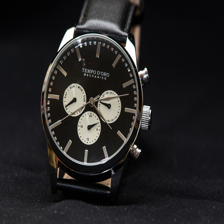

In [4]:
from PIL import Image
from urllib import request
from io import BytesIO
url = "https://github.com/ironmanciti/MachineLearningBasic/blob/master/datasets/TransferLearningData/watch.jpg?raw=true"
res = request.urlopen(url).read()
Sample_Image = Image.open(BytesIO(res)).resize((224, 224))

Sample_Image

tf.keras.applications.mobilenet.preprocess_input 함수는 이미지 데이터를 MobileNet 모델에 맞게 전처리하는 역할을 합니다. 이 함수는 주어진 이미지를 NumPy 배열로 변환하고, 모델에 사용되는 특정 범위로 픽셀 값을 조정합니다 (예: -1에서 1).

Sample_Image는 PIL.Image 객체로 크기가 (224, 224)로 조정되어 있습니다. 이 이미지를 np.array()를 사용하여 NumPy 배열로 변환한 다음, preprocess_input 함수를 사용하여 전처리를 수행합니다.

x의 차원 (224, 224, 3)는 전처리된 이미지가 224x224 크기의 컬러 이미지임을 나타냅니다. 각 숫자는 각각 높이, 너비, 색상 채널 (RGB)을 나타냅니다.

In [5]:
x = tf.keras.applications.mobilenet.preprocess_input(np.array(Sample_Image))
x.shape

(224, 224, 3)

np.expand_dims(x, axis=0)를 사용하여 이미지 배열의 모양을 (1, 224, 224, 3)으로 변경합니다. 이렇게 하면 입력 이미지가 하나의 배치로 처리되며, 모델은 한 번에 하나의 이미지를 예측할 수 있습니다.

In [6]:
predicted_class = Trained_Mobilenet.predict(np.expand_dims(x, axis = 0))

1/1 [==============================] - 8s 8s/step


decode_predictions 함수는 모델이 예측한 결과를 사람이 이해하기 쉬운 형태로 변환합니다. 이 함수는 예측된 클래스의 확률을 기반으로 상위 K개의 예측 결과를 반환합니다.  
predicted_class[:, 1:] 코드는 첫 번째 레이블(배경)을 제외한 나머지 확률 값을 추출합니다. 이렇게 하면 배경 레이블을 고려하지 않고 상위 예측 결과를 얻을 수 있습니다.

In [7]:
decode_predictions(predicted_class[:, 1:])  # 첫번째 label은 background

35363/35363 [==============================] - 0s 4us/step


[[('n04328186', 'stopwatch', 9.72039),
  ('n02708093', 'analog_clock', 8.040999),
  ('n03706229', 'magnetic_compass', 6.881803),
  ('n04548280', 'wall_clock', 6.6048107),
  ('n03075370', 'combination_lock', 4.9255204)]]

TensorFlow에서 제공하는 get_file 함수를 사용하여 'ImageNetLabels.txt' 파일을 다운로드합니다. 이 파일에는 ImageNet 데이터셋에 포함된 레이블들이 저장되어 있습니다. 다운로드된 파일은 labels_path 변수에 저장됩니다.  
open(labels_path).read().splitlines() 코드를 사용하여 다운로드한 텍스트 파일을 읽고 각 줄을 나눠 imagenet_labels라는 NumPy 배열에 저장합니다. 

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt',
                'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


In [9]:
print(imagenet_labels[:10])

['background' 'tench' 'goldfish' 'great white shark' 'tiger shark'
 'hammerhead' 'electric ray' 'stingray' 'cock' 'hen']


 np.argmax(predicted_class)를 사용하여 예측된 클래스 확률 중 가장 큰 값을 찾습니다.

Text(0.5, 1.0, 'Predicted Class is: Stopwatch')

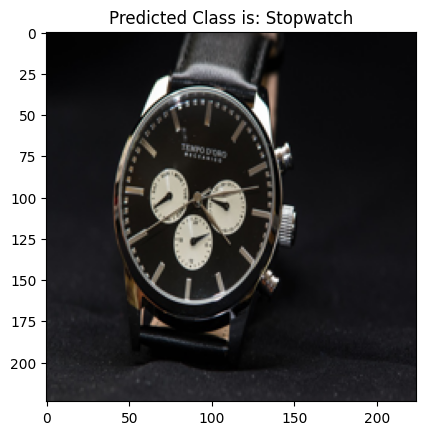

In [10]:
plt.imshow(Sample_Image)
predicted_class = imagenet_labels[np.argmax(predicted_class)]
plt.title("Predicted Class is: " + predicted_class.title())

###  Fine Tuning 전 특정 domain 의 Batch Image 에 대한 MobileNet 평가 

MobileNet 은 Flower 에 특화된 model 이 아니므로 정확도 낮을 것으로 예상됩니다.  
get_file 함수를 사용하여 인터넷에서 꽃 이미지 데이터셋을 다운로드합니다.    다운로드할 파일의 이름을 'flower_photos'로 지정하고, 데이터셋의 URL을 인자로 전달합니다. untar=True는 파일이 tar 압축 형식이므로 다운로드 후 압축을 풀어야 함을 나타냅니다.

In [11]:
# flowers dataset
flowers_data_path = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
    untar=True)

228813984/228813984 [==============================] - 10s 0us/step


TensorFlow의 ImageDataGenerator를 사용하여 꽃 이미지 데이터셋에 대한 데이터 전처리를 수행합니다. ImageDataGenerator는 실시간 데이터 전처리 및 증강을 수행하며, 이미지 파일을 학습 데이터로 변환하는 데 사용됩니다. 이 예제에서는 MobileNet의 전처리 함수를 사용하여 이미지를 전처리합니다.  
ImageDataGenerator 객체인 image_generator를 생성한 후, flow_from_directory 함수를 사용하여 로컬 파일 시스템에서 이미지를 로드하고 전처리합니다. 이 함수는 이미지를 로드하고, 지정된 target_size(224 x 224)로 크기를 조정하며, 배치 크기를 64로 설정하여 데이터를 배치 단위로 반환합니다. shuffle=True는 데이터를 무작위로 섞어 과적합을 방지합니다.


In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

flowers_data = image_generator.flow_from_directory(flowers_data_path, 
                    target_size=(224, 224), batch_size = 64, shuffle = True)

Found 3670 images belonging to 5 classes.


next() 함수를 사용하여 flowers_data에서 배치를 추출합니다.  
input_batch는 전처리된 이미지 데이터의 배치입니다. 이 경우, 배치 크기는 64이며, 각 이미지의 크기는 224 x 224 x 3이므로 배치의 모양(shape)은 (64, 224, 224, 3)입니다.  
label_batch는 이미지에 해당하는 원-핫 인코딩된 레이블 데이터의 배치입니다. 이 경우, 클래스 수가 5개이므로 레이블 배치의 모양은 (64, 5)입니다.  
flowers_data.num_classes는 데이터셋의 클래스 수를 반환합니다. 이 경우, 꽃 데이터셋에는 5개의 클래스가 있습니다.  
flowers_data.class_indices는 클래스 이름과 해당 인덱스를 포함하는 딕셔너리입니다. 이 정보는 이미지의 실제 레이블과 예측된 레이블을 비교할 때 유용합니다.

In [13]:
input_batch, label_batch = next(flowers_data)

print("Image batch shape: ", input_batch.shape)
print("Label batch shape: ", label_batch.shape)
print("Label class 수: ", flowers_data.num_classes)
print("Class Index : ", flowers_data.class_indices)

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)
Label class 수:  5
Class Index :  {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


 flowers_data.class_indices 딕셔너리의 키와 값의 위치를 바꾸어 새로운 딕셔너리 class_names를 생성합니다. 이렇게 하면, 인덱스를 사용하여 각 클래스의 이름을 쉽게 찾을 수 있습니다.

In [14]:
class_names = {v:k for k,v in flowers_data.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

첫 번째 배치에서 10개의 이미지를 시각화하여 그리드에 표시 합니다. 각 이미지의 전처리를 되돌려 정규화된 값을 원래 이미지의 값으로 변환합니다.

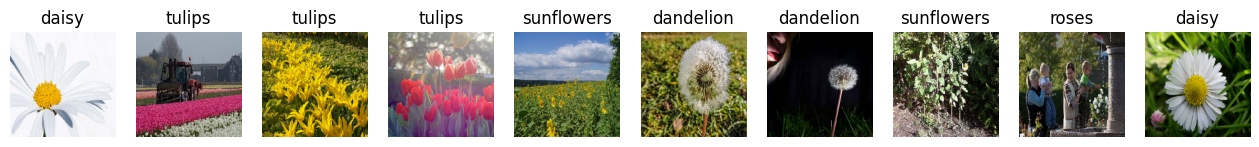

In [15]:
plt.figure(figsize=(16, 8))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    idx  = np.argmax(label_batch[i])
    plt.imshow(img)
    plt.title(class_names[idx])
    plt.axis('off')

임의의 꽃 image 1 개를 선택하여  예측을 수행합니다.


In [16]:
prediction = Trained_Mobilenet.predict(input_batch[2:3])
prediction.shape

1/1 [==============================] - 0s 21ms/step


(1, 1001)

decode_predictions() 함수는 1000개의 클래스 레이블 중 확률이 가장 높은 상위 5개 결과를 인간이 이해할 수 있는 레이블로 변환해주는 함수입니다.  이 레이블은 [(class_id, class_name, class_probability)] 형태의 튜플 리스트로 반환합니다.


In [17]:
decode_predictions(prediction[:, 1:])  

[[('n03496892', 'harvester', 7.5885015),
  ('n03000134', 'chainlink_fence', 5.5772314),
  ('n03393912', 'freight_car', 5.0751047),
  ('n03967562', 'plow', 4.7416353),
  ('n03388043', 'fountain', 4.689434)]]

### 전이학습 MODEL 을 Flower 분류에 적합한 model 로 Retrain 

### Fine Tuning 을 위해 head 가 제거된 model 을 download  

- https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

In [18]:
extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

extractor_layer = hub.KerasLayer(extractor_url, input_shape=(224, 224, 3))

extractor_layer를 통해 입력 이미지 배치를 모바일넷으로 처리한 특성 벡터 배치를 얻습니다. 반환된 feature_batch의 shape를 출력해보면면, 64개의 이미지에 대해, 각 이미지는 1280 차원의 특성 벡터로 나타납니다.

In [19]:
feature_batch = extractor_layer(input_batch)
print(feature_batch.shape)

(64, 1280)


extractor_layer.trainable = False는 모델의 특정 레이어를 학습에서 제외시키는 역할을 합니다. 이를 통해 레이어의 가중치가 업데이트되지 않도록 하여 해당 레이어의 특성을 고정시켜 놓을 수 있습니다. 

In [20]:
extractor_layer.trainable = False

### Model을 두 부분으로 구성:
-    (1)  MobileNet Feature Extractor 
-   (2)  출력 부분에 Dense Network (classifier) 추가 

In [21]:
model = tf.keras.Sequential([
  extractor_layer,
  tf.keras.layers.Dense(flowers_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
model.input, model.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_1_input')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>)

- output shape 이 정확한지 training 전에 사전 check해 봅니다.

In [23]:
predictions = model(input_batch)

In [24]:
predictions.shape

TensorShape([64, 5])

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(flowers_data, epochs=30)

Epoch 1/30
58/58 [==============================] - 19s 259ms/step - loss: 0.9206 - accuracy: 0.6531
Epoch 2/30
58/58 [==============================] - 14s 246ms/step - loss: 0.4809 - accuracy: 0.8365
Epoch 3/30
58/58 [==============================] - 15s 252ms/step - loss: 0.3934 - accuracy: 0.8643
Epoch 4/30
58/58 [==============================] - 14s 248ms/step - loss: 0.3424 - accuracy: 0.8847
Epoch 5/30
58/58 [==============================] - 14s 246ms/step - loss: 0.3023 - accuracy: 0.9057
Epoch 6/30
58/58 [==============================] - 14s 247ms/step - loss: 0.2804 - accuracy: 0.9112
Epoch 7/30
58/58 [==============================] - 14s 248ms/step - loss: 0.2631 - accuracy: 0.9161
Epoch 8/30
58/58 [==============================] - 14s 236ms/step - loss: 0.2428 - accuracy: 0.9262
Epoch 9/30
58/58 [==============================] - 14s 242ms/step - loss: 0.2196 - accuracy: 0.9330
Epoch 10/30
58/58 [==============================] - 14s 248ms/step - loss: 0.2072 - accura

### Flower 분류 전문으로 Fine Tuning 된 MODEL 평가

np.argmax() 함수를 이용하여 각 샘플의 예측값 중 가장 큰 값(즉, 가장 높은 확률값)에 해당하는 인덱스를 y_pred에 저장합니다.

In [27]:
y_pred = model.predict(input_batch)
y_pred = np.argmax(y_pred, axis=-1)
y_pred

2/2 [==============================] - 1s 13ms/step


array([2, 0, 4, 4, 4, 3, 1, 1, 3, 2, 0, 2, 1, 1, 0, 1, 1, 2, 2, 3, 0, 2,
       2, 4, 3, 3, 1, 0, 2, 4, 0, 4, 3, 1, 3, 0, 2, 2, 2, 2, 4, 4, 1, 1,
       1, 0, 4, 4, 4, 2, 2, 0, 3, 0, 3, 0, 0, 0, 1, 4, 1, 3, 2, 0])

In [28]:
y_true = np.argmax(label_batch, axis=-1)
y_true

array([2, 0, 4, 4, 4, 3, 1, 1, 3, 2, 0, 2, 1, 1, 0, 1, 1, 2, 2, 3, 0, 2,
       2, 4, 3, 3, 1, 0, 2, 4, 0, 4, 3, 1, 3, 0, 2, 2, 2, 2, 4, 4, 1, 1,
       1, 0, 4, 4, 4, 2, 2, 0, 3, 0, 3, 0, 0, 0, 1, 4, 1, 3, 2, 0])

 y_pred와 y_true 간의 일치하는 값의 비율을 계산하여 백분율로 나타냅니다

In [31]:
f"{sum(y_pred == y_true) / len(y_true) * 100:.2f} %"

'100.00 %'

이전과 마찬가지로  각 이미지의 전처리를 되돌려 정규화된 값을 원래 이미지의 값으로 변환합니다.

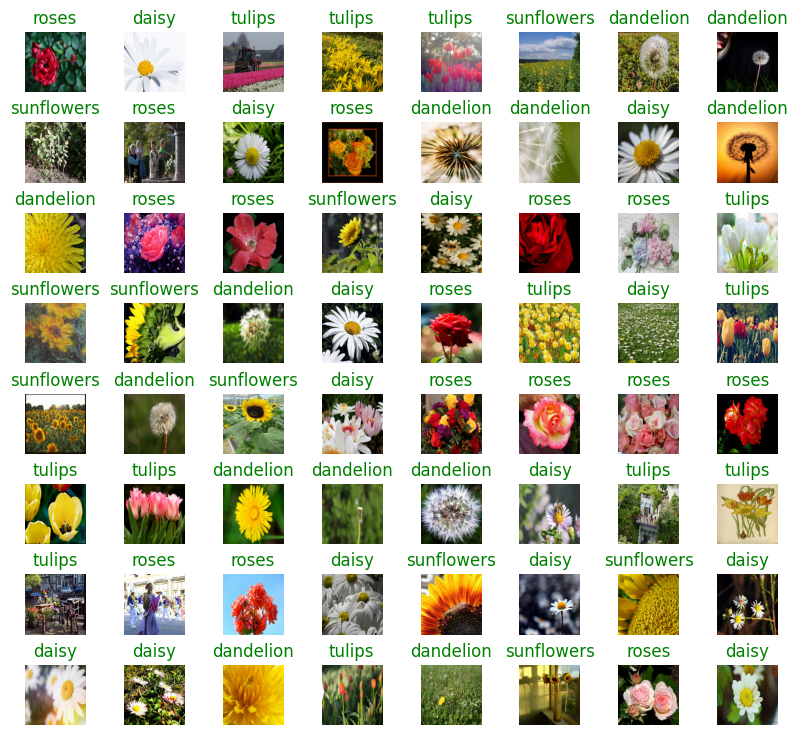

In [30]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for i in range(64):
    plt.subplot(8, 8, i+1)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    plt.imshow(img)
    color = "green" if y_pred[i] == y_true[i] else "red"
    plt.title(class_names[y_pred[i]], color=color)
    plt.axis('off')
